# Loading Dataset

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split, KFold
from tensorflow import keras
import keras_tuner as kt
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
def load_dataset(path):
    return pd.read_csv(path)

In [4]:
file_path='./nTFT/NULB/NUBL.csv'
df_stock = load_dataset(file_path)

In [4]:
df_stock

,S.N.,Date,Open,High,Low,Ltp,% Change,Qty,Turnover
0,2476,06/04/2011,225,225,225,225,0.00,64,"14,400.00"
1,2475,12/05/2011,225,229,225,225,0.00,59,"13,427.00"
2,2474,15/05/2011,225,229,229,229,0.00,57,"13,053.00"
3,2473,16/05/2011,229,230,230,230,0.00,20,"4,600.00"
4,2472,18/05/2011,230,230,230,230,0.00,22,"5,060.00"
...,...,...,...,...,...,...,...,...,...
2471,5,09/05/2024,683,689.6,662.6,670,-0.89,"14,540.00","97,68,167.80"
2472,4,12/05/2024,670,670,650.3,650.3,-2.94,"6,884.00","45,11,826.40"
2473,3,13/05/2024,650,658,645,651,0.11,"5,463.00","35,48,046.70"
2474,2,14/05/2024,655,674.9,655,671,3.07,"18,718.00","1,25,18,869.30"


In [5]:
print("\nBasic statistics:")
print(df_stock.describe())


Basic statistics:
              S.N.     % Change
count  2476.000000  2476.000000
mean   1238.500000     0.020586
std     714.903956     1.666216
min       1.000000   -20.660000
25%     619.750000    -0.342500
50%    1238.500000     0.000000
75%    1857.250000     0.000000
max    2476.000000    10.000000


In [6]:
# Check for missing values
print("\nMissing values:")
print(df_stock.isnull().sum())


Missing values:
S.N.        0
Date        0
Open        0
High        0
Low         0
Ltp         0
% Change    0
Qty         0
Turnover    0
dtype: int64


In [7]:
df_stock = pd.read_csv('./NULBdata.csv', index_col='Date', parse_dates=True, dayfirst=True)
df_stock['Date'] = pd.to_datetime(df_stock.index, dayfirst=True) 

In [8]:
df_stock=df_stock.rename(columns={'% Change':'Change'})
df_stock


,S.N.,Open,High,Low,Ltp,Change,Qty,Turnover,Date
Date,,,,,,,,,
2011-04-06,2476,225,225,225,225,0.00,64,"14,400.00",2011-04-06
2011-05-12,2475,225,229,225,225,0.00,59,"13,427.00",2011-05-12
2011-05-15,2474,225,229,229,229,0.00,57,"13,053.00",2011-05-15
2011-05-16,2473,229,230,230,230,0.00,20,"4,600.00",2011-05-16
2011-05-18,2472,230,230,230,230,0.00,22,"5,060.00",2011-05-18
...,...,...,...,...,...,...,...,...,...
2024-05-09,5,683,689.6,662.6,670,-0.89,"14,540.00","97,68,167.80",2024-05-09
2024-05-12,4,670,670,650.3,650.3,-2.94,"6,884.00","45,11,826.40",2024-05-12
2024-05-13,3,650,658,645,651,0.11,"5,463.00","35,48,046.70",2024-05-13


In [9]:
features = ['Date','Open', 'High', 'Low', 'Ltp', 'Change', 'Qty', 'Turnover']
df_stock = df_stock[features]

In [10]:
# import datetime

# def str_to_datetime(s):
#     split = s.split('/')
#     day, month, year = int(split[0]), int(split[1]), int(split[2])
#     return datetime.datetime(year=year, month=month, day=day)

df_stock['Date'] = pd.to_datetime(df_stock['Date'], format='%d/%m/%Y')


In [11]:
df_input = df_stock[['Date','Open', 'High', 'Low', 'Ltp', 'Change', 'Qty', 'Turnover']]

In [12]:
def min_max_scaling(data):
    min_val = np.min(data)
    max_val = np.max(data)
    scaled_data = (data - min_val) / (max_val - min_val)
    return scaled_data, min_val, max_val

In [13]:
# columns_to_scale = ['Date','Open', 'High', 'Low', 'Ltp', 'Change', 'Qty', 'Turnover']
# scaled_df = df_input.copy()

In [14]:

df_stock['Open'] = df_stock['Open'].astype(str)
df_stock['High'] = df_stock['High'].astype(str)
df_stock['Low'] = df_stock['Low'].astype(str)
df_stock['Ltp'] = df_stock['Ltp'].astype(str)
df_stock['Qty'] = df_stock['Qty'].astype(str)
df_stock['Turnover'] = df_stock['Turnover'].astype(str)


df_stock['Open'] = df_stock['Open'].str.replace(',', '').astype(float)
df_stock['High'] = df_stock['High'].str.replace(',', '').astype(float)
df_stock['Low'] = df_stock['Low'].str.replace(',', '').astype(float)
df_stock['Ltp'] = df_stock['Ltp'].str.replace(',', '').astype(float)
df_stock['Qty'] = df_stock['Qty'].str.replace(',', '').astype(float)
df_stock['Turnover'] = df_stock['Turnover'].str.replace(',', '').astype(float)
df_stock['Change'] = df_stock['Change'].astype(float)
df_stock['Date'] = pd.to_datetime(df_stock['Date'], format='%d/%m/%Y')


df_stock['day_of_week'] = df_stock['Date'].dt.dayofweek
df_stock['month'] = df_stock['Date'].dt.month


/var/folders/7c/t7xk5xzs13b_2t3d5fd1zg4w0000gn/T/ipykernel_52750/1056539094.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock['Open'] = df_stock['Open'].astype(str)
/var/folders/7c/t7xk5xzs13b_2t3d5fd1zg4w0000gn/T/ipykernel_52750/1056539094.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock['High'] = df_stock['High'].astype(str)
/var/folders/7c/t7xk5xzs13b_2t3d5fd1zg4w0000gn/T/ipykernel_52750/1056539094.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

In [15]:
features = ['Open', 'High', 'Low', 'Ltp', 'Change', 'Qty', 'Turnover', 'day_of_week', 'month']
df_stock = df_stock[features]

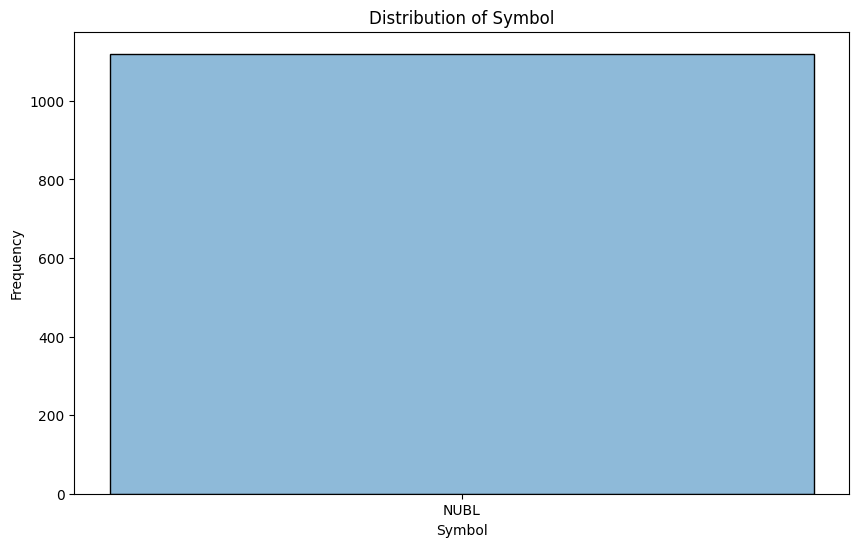

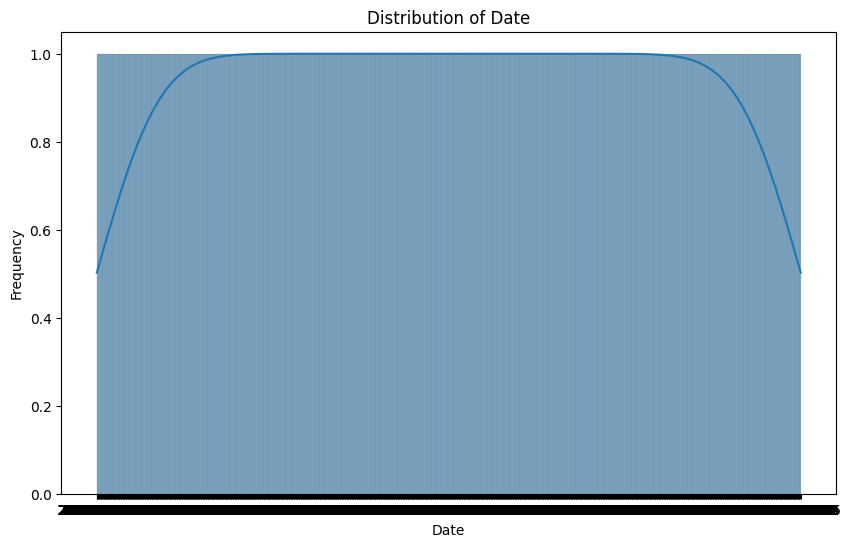

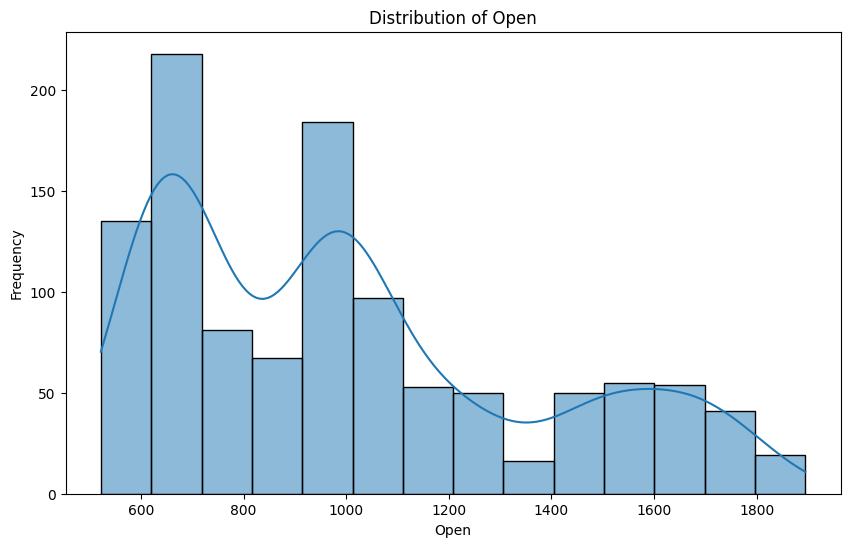

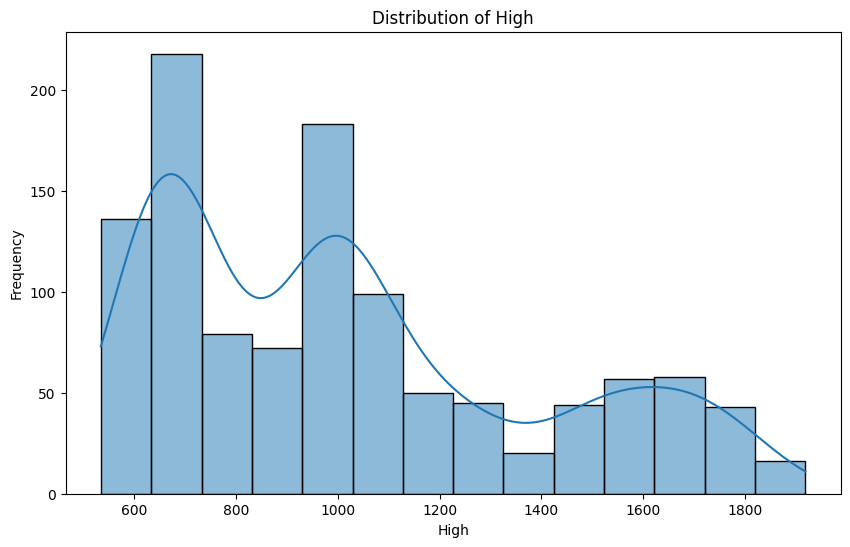

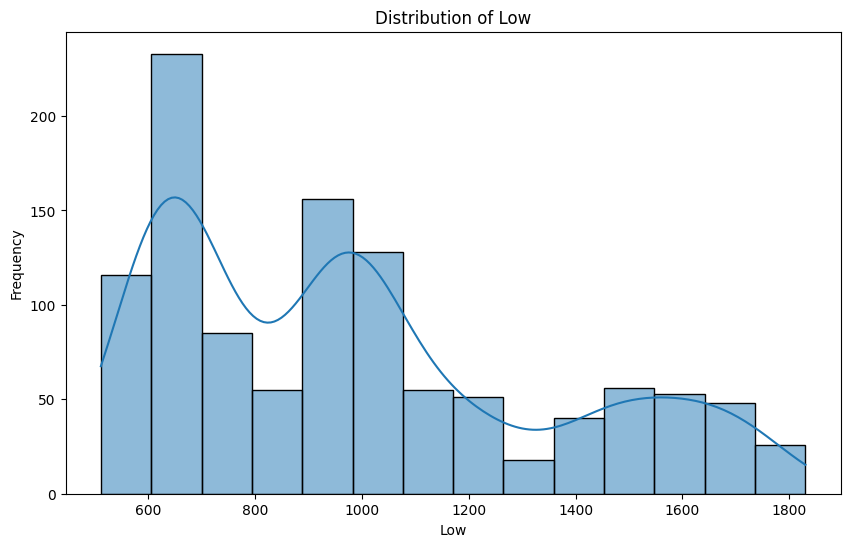

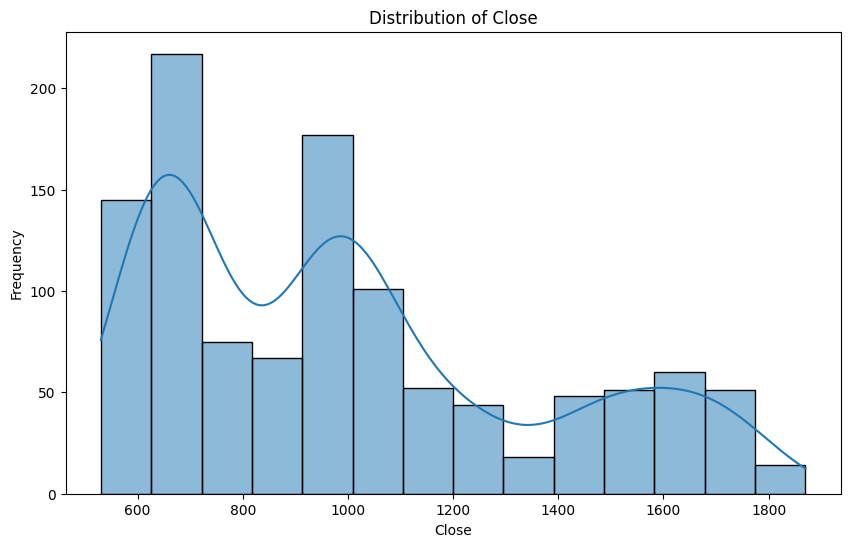

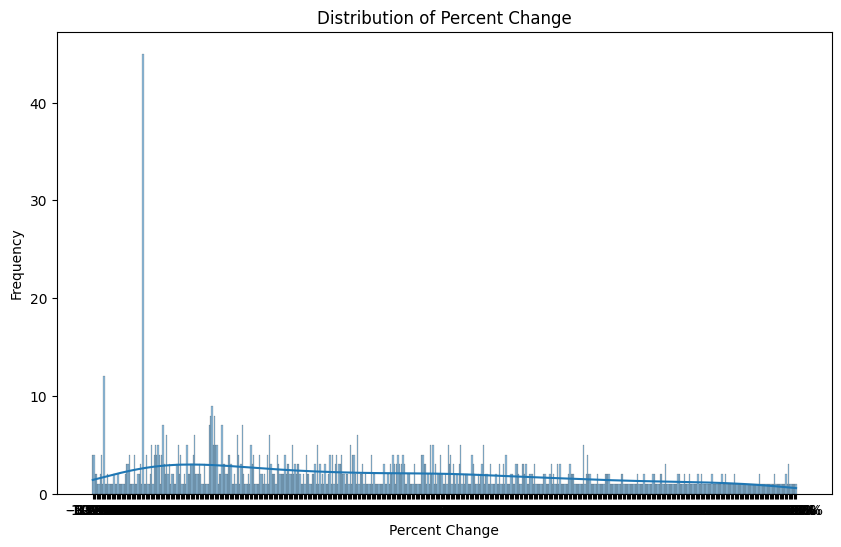

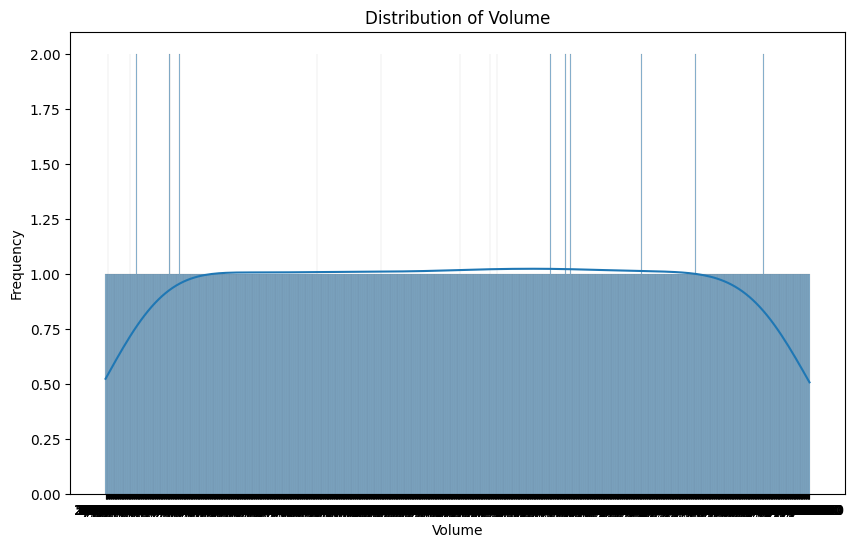

In [5]:
import seaborn as sns

def plot_distribution(df, column):
    plt.figure(figsize=(10, 6))
    sns.histplot(df[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

for column in df_stock.columns:
    plot_distribution(df_stock, column)

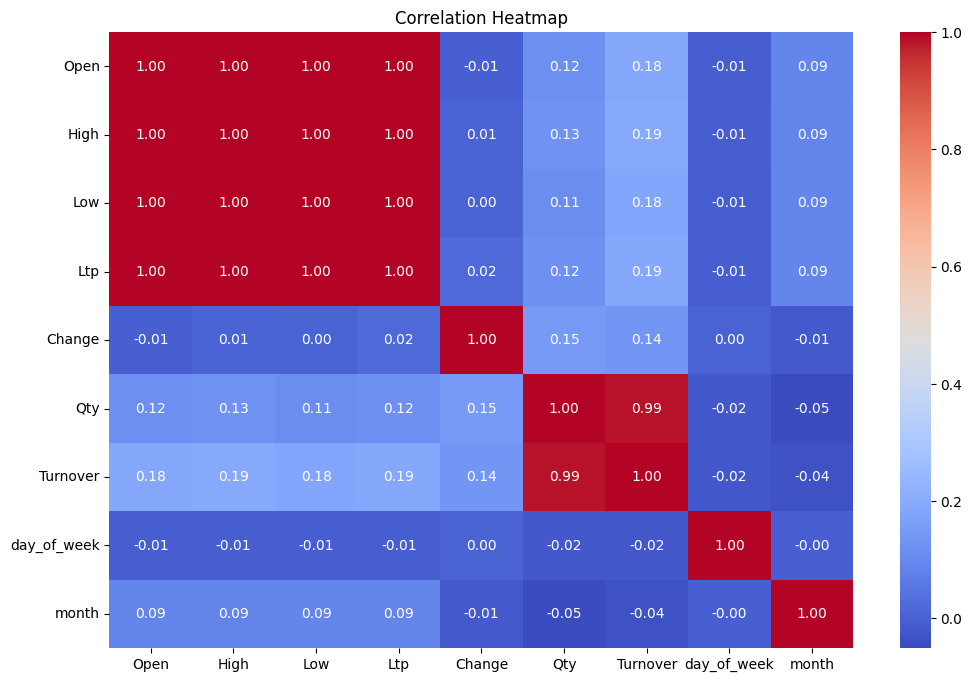

In [17]:
# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df_stock.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

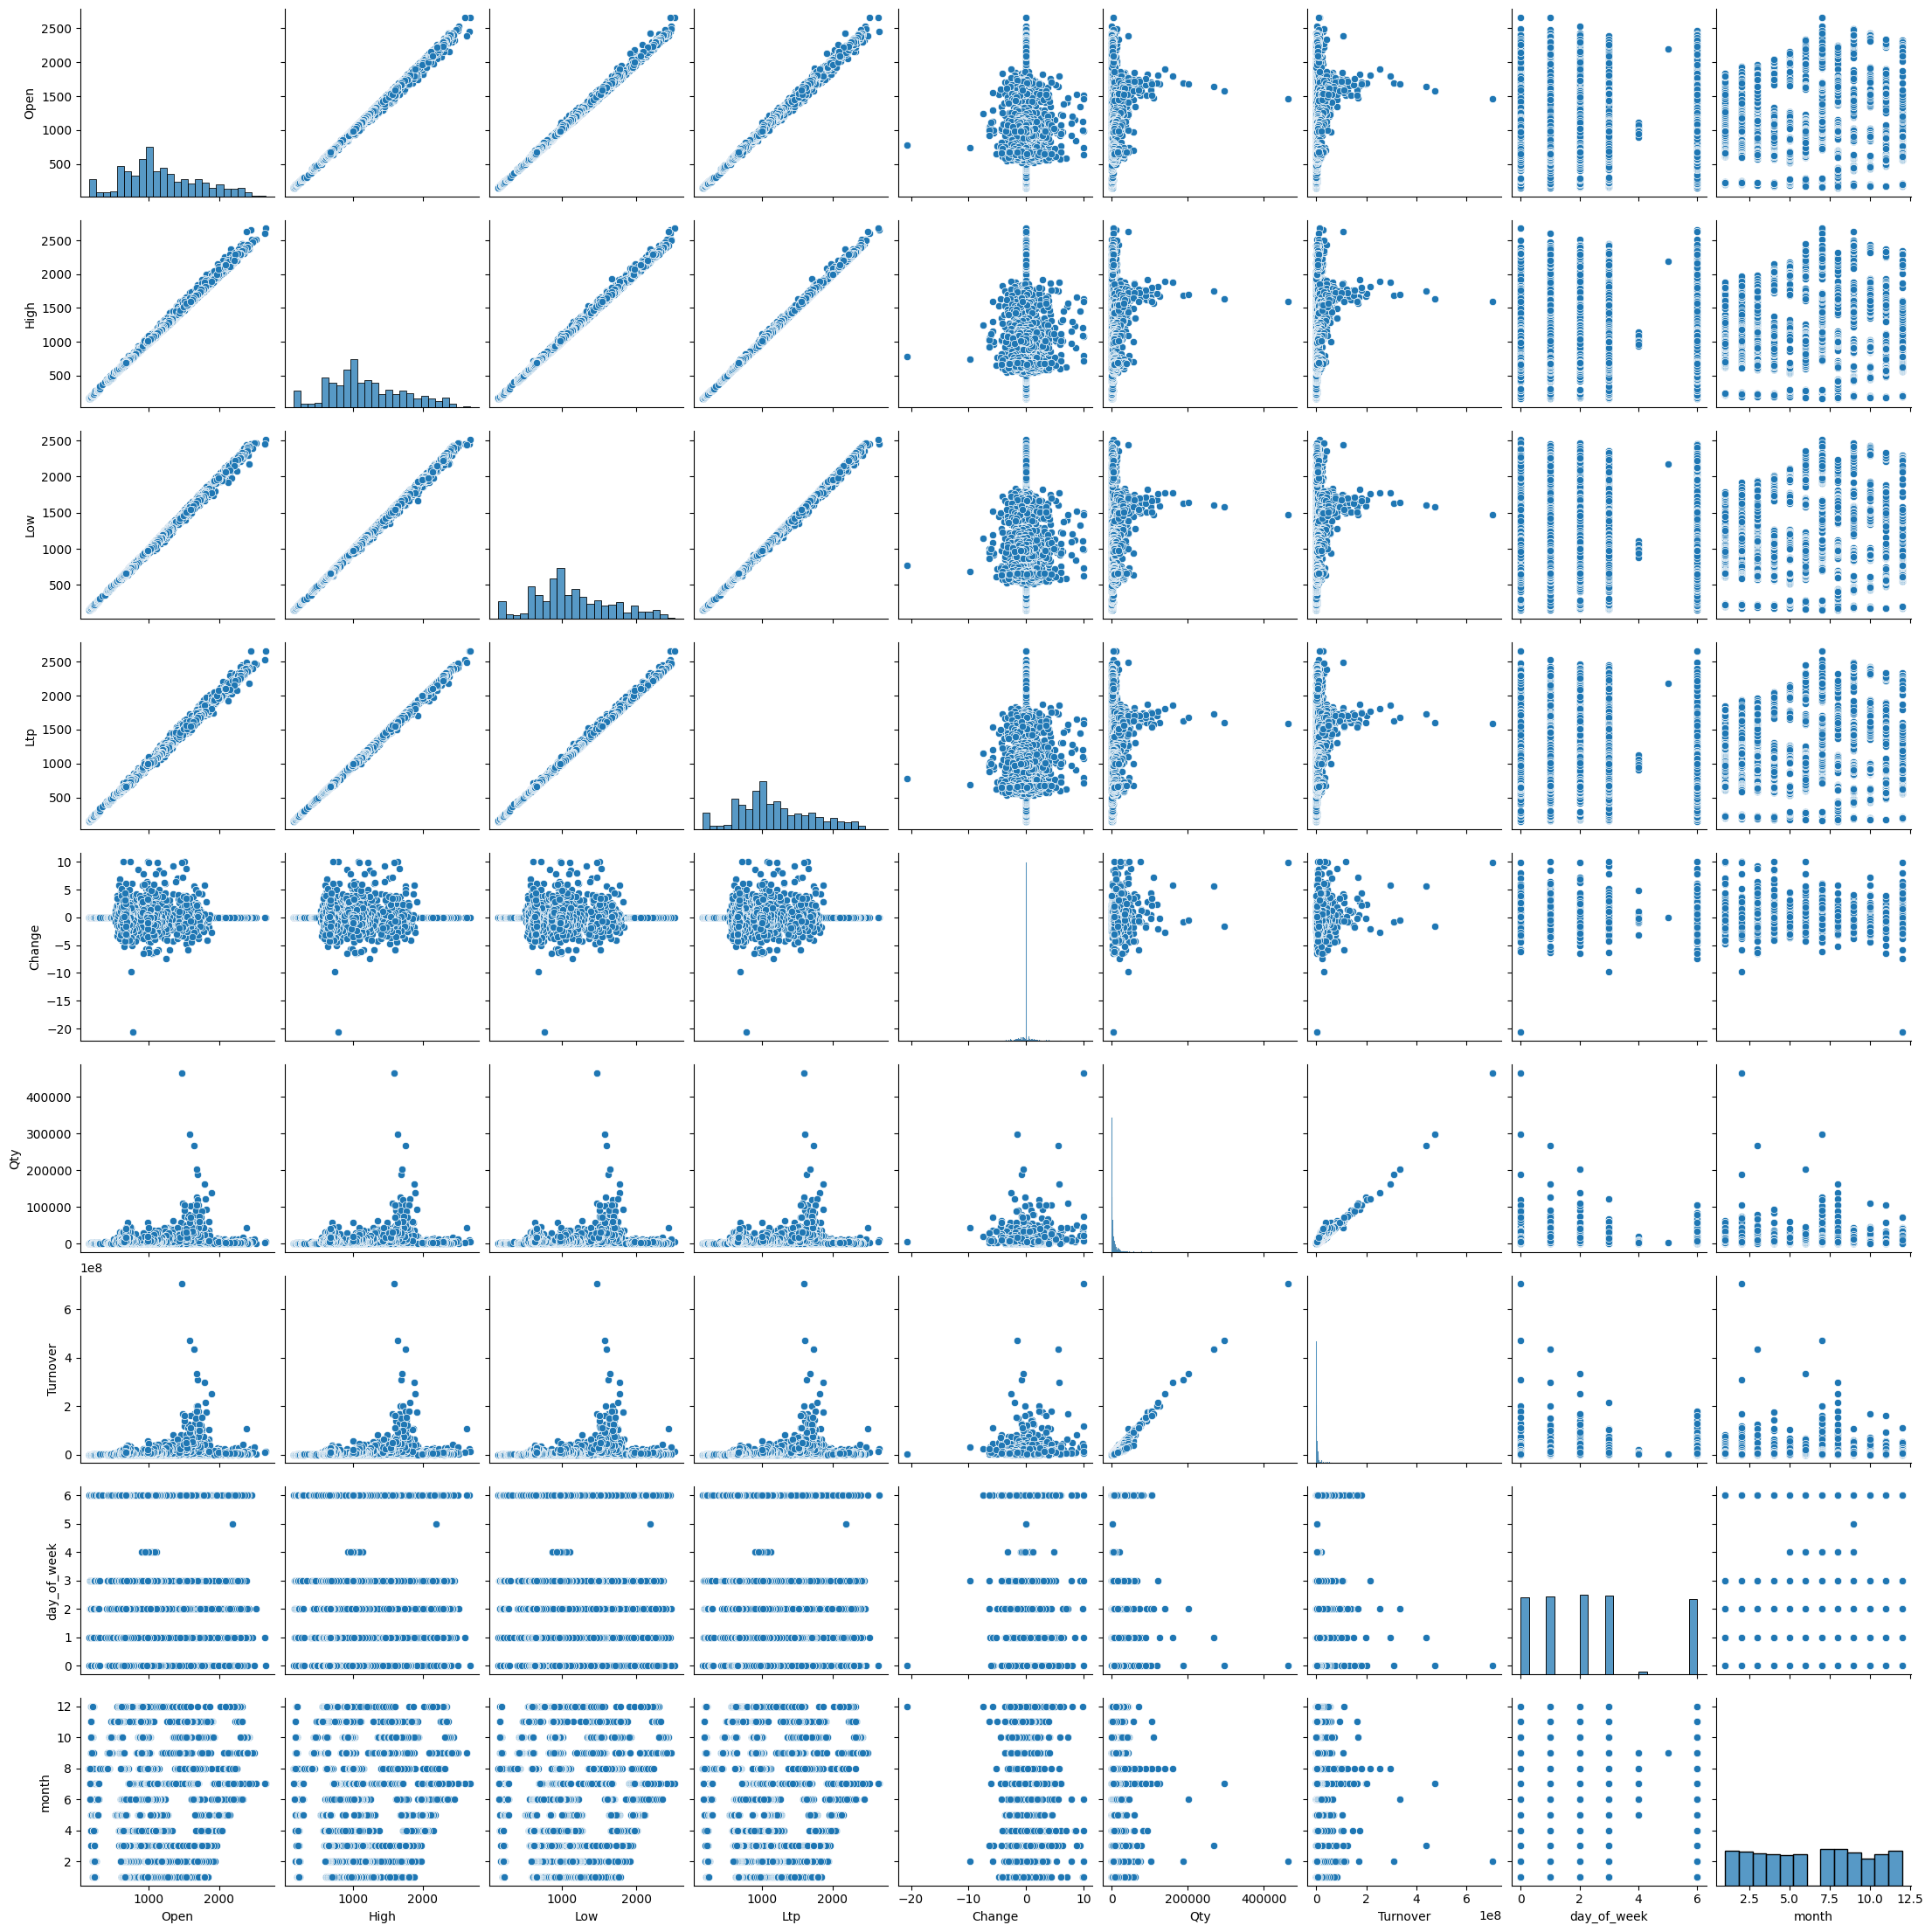

In [18]:

sns.pairplot(df_stock)
plt.show()

In [19]:
from sklearn.preprocessing import MinMaxScaler
import joblib
scaler = MinMaxScaler()
features = ['Open', 'High', 'Low', 'Ltp', 'Change', 'Qty', 'Turnover', 'day_of_week', 'month']
df_scaled = pd.DataFrame(scaler.fit_transform(df_stock[features]), columns=features)

joblib.dump(scaler, 'scaler.pkl')


['scaler.pkl']

In [20]:
def df_to_X_y(df, window_size=5):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np) - window_size):
        X.append(df_as_np[i:i + window_size])
        y.append(df_as_np[i + window_size][3])  # Index of LTP
    return np.array(X), np.array(y)

In [21]:
WINDOW_SIZE = 6
X, y = df_to_X_y(df_scaled, WINDOW_SIZE)

In [22]:

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow import keras
from tensorflow.keras import layers



In [23]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size,
        num_heads=num_heads,
        dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res


In [24]:
from tensorflow.keras.callbacks import EarlyStopping

In [25]:
def variable_selection_network(inputs):
    x = layers.Dense(64, activation='relu')(inputs)
    x = layers.Dense(1, activation='sigmoid')(x)
    return x

In [26]:
def gated_residual_network(inputs, units):
    x = layers.Dense(units, activation='relu')(inputs)
    x = layers.Dense(inputs.shape[-1])(x)
    gate = layers.Dense(inputs.shape[-1], activation='sigmoid')(inputs)
    return x * gate + inputs

In [27]:
def build_tft_model(hp):
    input_shape = (6, 9)
    inputs = layers.Input(shape=input_shape)
    x = inputs
    vsn_output = variable_selection_network(x)
    x = x * vsn_output
    x = layers.LSTM(units=50, return_sequences=True)(x)  
    x = layers.LSTM(units=50, return_sequences=True)(x)
    for i in range(hp.Int('num_transformer_blocks', min_value=2, max_value=8, step=2)):
        x = transformer_encoder(
            x,
            head_size=hp.Int('head_size', min_value=8, max_value=256, step=32),
            num_heads=hp.Int('num_heads', min_value=2, max_value=16),
            ff_dim=hp.Int('ff_dim', min_value=4, max_value=64),
            dropout=hp.Float(f'dropout_{i}', min_value=0.1, max_value=0.6)
        )
    x = gated_residual_network(x, units=hp.Int('grn_units', min_value=32, max_value=128, step=32))
    x = layers.GlobalAveragePooling1D()(x)
    for i in range(hp.Int('num_mlp_layers', min_value=1, max_value=3)):
        x = layers.Dense(hp.Int(f'mlp_units_{i}', min_value=32, max_value=256, step=32))(x)
        x = layers.Activation('relu')(x)
        x = layers.Dropout(hp.Float(f'mlp_dropout_{i}', min_value=0.1, max_value=0.6))(x)
    outputs = layers.Dense(1)(x)
    model = models.Model(inputs, outputs)
    optimizer_name = hp.Choice('optimizer', values=['adam', 'adamax'])
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
    if optimizer_name == 'adam':
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        optimizer = keras.optimizers.Adamax(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='mean_absolute_error',
        metrics=['mean_absolute_error']
    )
    return model

In [28]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from tensorflow.keras import layers
from tensorflow import keras

In [29]:
# Nested Cross-Validation
import numpy as np
from sklearn.model_selection import KFold
import keras_tuner as kt

best_model_hyperparameters = None
best_model_mae = float('inf')
worst_model_hyperparameters = None
worst_model_mae = float('-inf')

In [33]:
# Hyperparameter tuning
import keras_tuner as kt

# Set up the tuner
tuner = kt.RandomSearch(
    build_tft_model,
    objective='val_loss',
    max_trials=30,
    directory='./tft_tuning',
    project_name='tft_project'
)

# Perform the hyperparameter search
tuner.search(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Reloading Tuner from ./tft_tuning/tft_project/tuner0.json


In [34]:
# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=100)

# Run the tuner
tuner.search(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

In [35]:
nested_scores = []
outer_cv = KFold(n_splits=5, shuffle=True, random_state=100)

In [36]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=5)[0]

# Build the model with the optimal hyperparameters
model = build_tft_model(best_hps)



In [37]:
from tensorflow.keras.optimizers import Adam, Adamax

In [38]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [39]:
# Define a function to plot training and validation loss
def plot_loss(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [40]:
# Define a function to plot training and validation MAE
def plot_mae(history):
    plt.figure(figsize=(10, 6))
    if 'mean_absolute_error' in history.history and 'val_mean_absolute_error' in history.history:
        plt.plot(history.history['mean_absolute_error'], label='Training MAE')
        plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
        plt.title('Training and Validation MAE')
        plt.xlabel('Epochs')
        plt.ylabel('MAE')
        plt.legend()
        plt.show()
    else:
        print("MAE metric not found in history.")


In [41]:
# Define a function to plot training and validation MSE
def plot_mse(history):
    plt.figure(figsize=(10, 6))
    if 'mean_squared_error' in history.history and 'val_mean_squared_error' in history.history:
        plt.plot(history.history['mean_squared_error'], label='Training MSE')
        plt.plot(history.history['val_mean_squared_error'], label='Validation MSE')
        plt.title('Training and Validation MSE')
        plt.xlabel('Epochs')
        plt.ylabel('MSE')
        plt.legend()
        plt.show()
    else:
        print("MSE metric not found in history.")

In [42]:
print("Shape of X:", X.shape)


Shape of X: (2470, 6, 9)


Reloading Tuner from ./keras_tuner_random_dir_fold_tf_0_0/hyperparameter_random_tuning_fold_tf_0_0/tuner0.json
Best hyperparameters for fold 0: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x154897860>
Epoch 1/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - loss: 0.9888 - mean_absolute_error: 0.9888 - val_loss: 0.3054 - val_mean_absolute_error: 0.3054
Epoch 2/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - loss: 0.3649 - mean_absolute_error: 0.3649 - val_loss: 0.1260 - val_mean_absolute_error: 0.1260
Epoch 3/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 0.2274 - mean_absolute_error: 0.2274 - val_loss: 0.2927 - val_mean_absolute_error: 0.2927
Epoch 4/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - loss: 0.1833 - mean_absolute_error: 0.1833 - val_loss: 0.0643 - val_mean_absolute_error: 0.0643
Epoch 5/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - loss: 0.1479 - mean_absolute_error: 0.1479 - val_loss: 0.1297 - val_mean_absolute_error: 0.1297


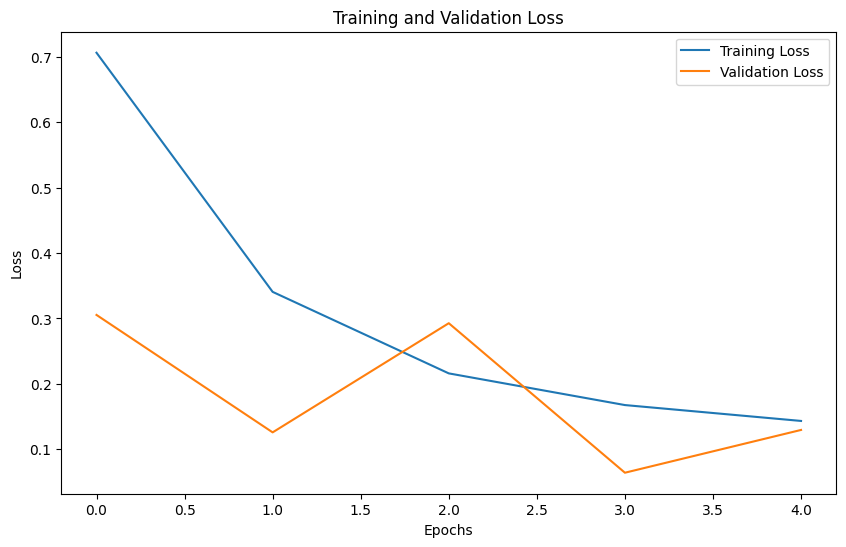

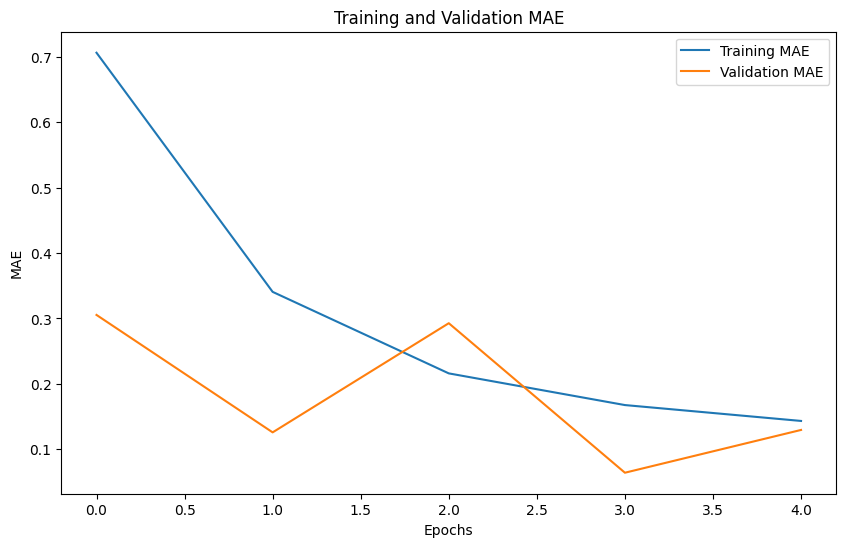

MSE metric not found in history.
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step
Reloading Tuner from ./keras_tuner_random_dir_fold_tf_0_1/hyperparameter_random_tuning_fold_tf_0_1/tuner0.json
Best hyperparameters for fold 1: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x144a4bc80>
Epoch 1/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 150ms/step - loss: 0.7328 - mean_absolute_error: 0.7328 - val_loss: 0.2209 - val_mean_absolute_error: 0.2209
Epoch 2/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - loss: 0.2383 - mean_absolute_error: 0.2383 - val_loss: 0.1925 - val_mean_absolute_error: 0.1925
Epoch 3/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - loss: 0.1909 - mean_absolute_error: 0.1909 - val_loss: 0.1651 - val_mean_absolute_error: 0.1651
Epoch 4/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - loss: 0.1669 - mean_absolute_error: 0.1669 - val_loss: 0.0648 - val_mean_absolute_error: 0.0648
Epoch 5/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - loss: 0.1388 - mean_absolute_error: 0.

<Figure size 1000x600 with 0 Axes>

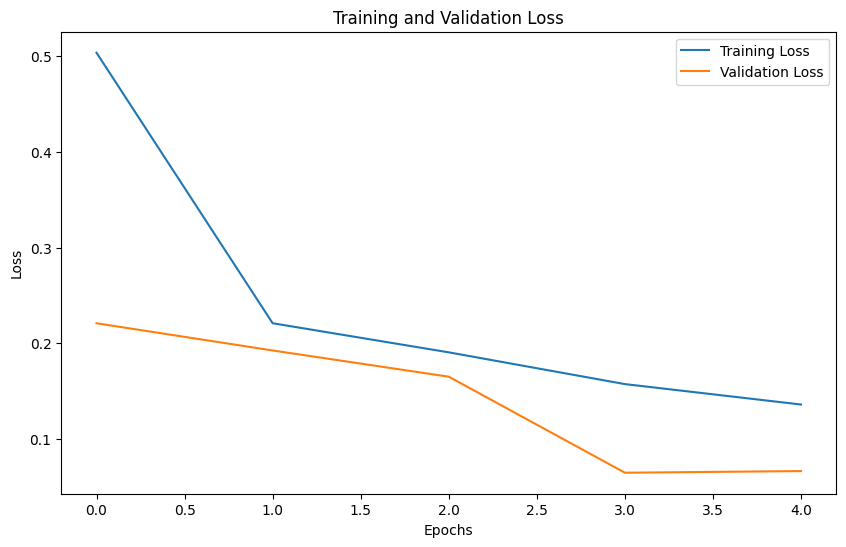

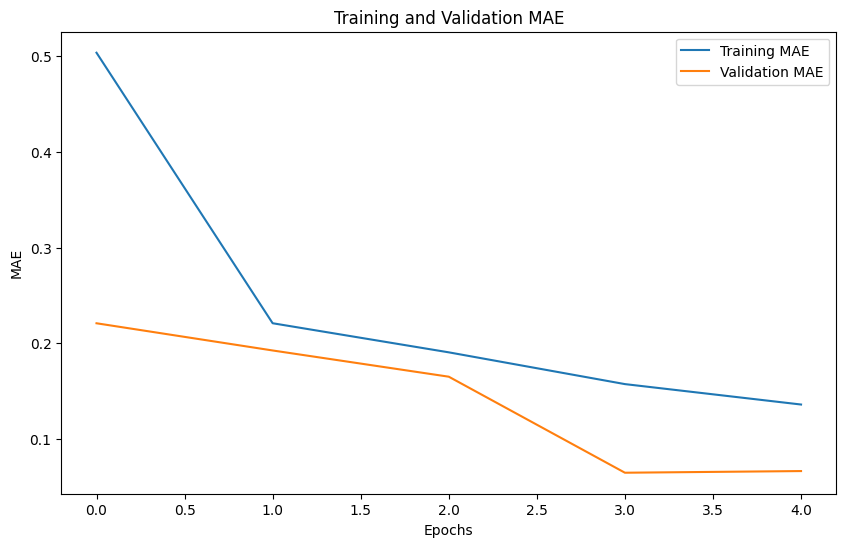

MSE metric not found in history.
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
Reloading Tuner from ./keras_tuner_random_dir_fold_tf_1_0/hyperparameter_random_tuning_fold_tf_1_0/tuner0.json
Best hyperparameters for fold 0: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x142e18ef0>
Epoch 1/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - loss: 0.3819 - mean_absolute_error: 0.3819 - val_loss: 0.0727 - val_mean_absolute_error: 0.0727
Epoch 2/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.1605 - mean_absolute_error: 0.1605 - val_loss: 0.0747 - val_mean_absolute_error: 0.0747
Epoch 3/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.1440 - mean_absolute_error: 0.1440 - val_loss: 0.1018 - val_mean_absolute_error: 0.1018
Epoch 4/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.1157 - mean_absolute_error: 0.1157 - val_loss: 0.1010 - val_mean_absolute_error: 0.1010
Epoch 5/5
31/31 

<Figure size 1000x600 with 0 Axes>

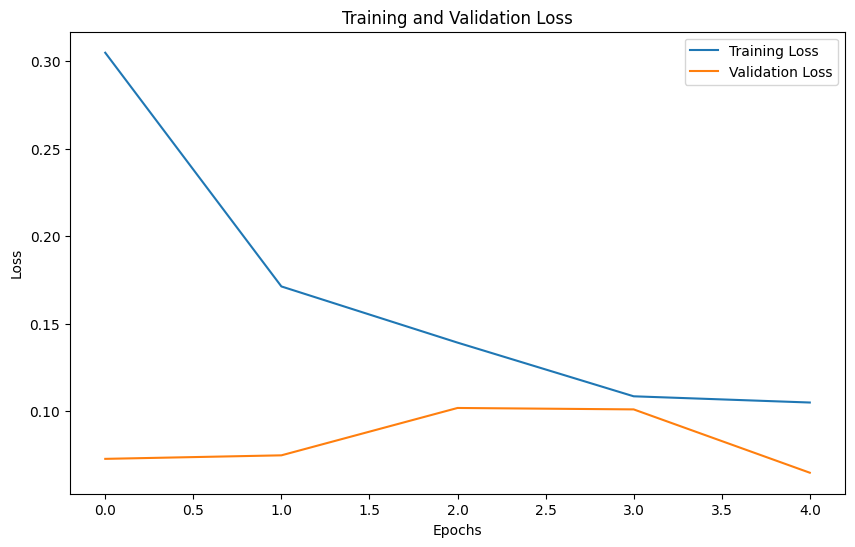

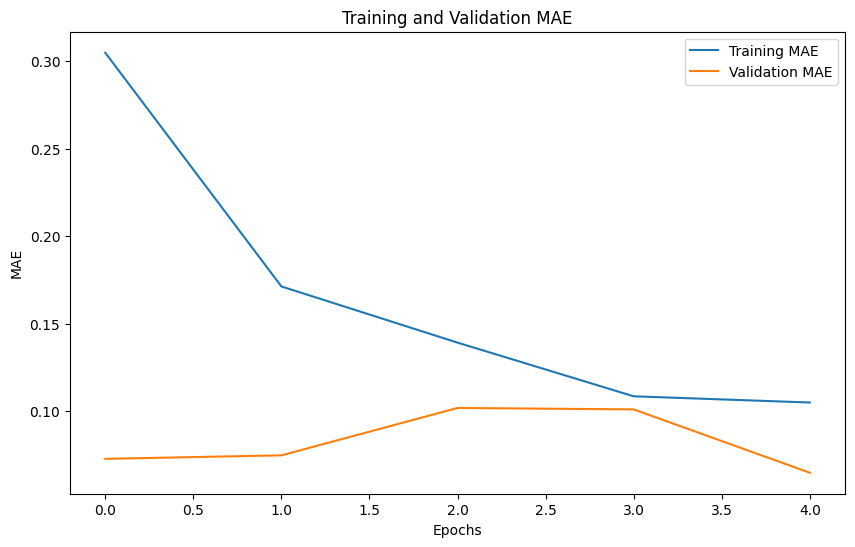

MSE metric not found in history.
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Reloading Tuner from ./keras_tuner_random_dir_fold_tf_1_1/hyperparameter_random_tuning_fold_tf_1_1/tuner0.json
Best hyperparameters for fold 1: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x177eadd00>
Epoch 1/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - loss: 0.5955 - mean_absolute_error: 0.5955 - val_loss: 0.1012 - val_mean_absolute_error: 0.1012
Epoch 2/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1663 - mean_absolute_error: 0.1663 - val_loss: 0.0686 - val_mean_absolute_error: 0.0686
Epoch 3/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1143 - mean_absolute_error: 0.1143 - val_loss: 0.1253 - val_mean_absolute_error: 0.1253
Epoch 4/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.1160 - mean_absolute_error: 0.1160 - val_loss: 0.0910 - val_mean_absolute_error: 0.0910
Epoch 5/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.1065 - mean_absolute_error: 0.1065 -

<Figure size 1000x600 with 0 Axes>

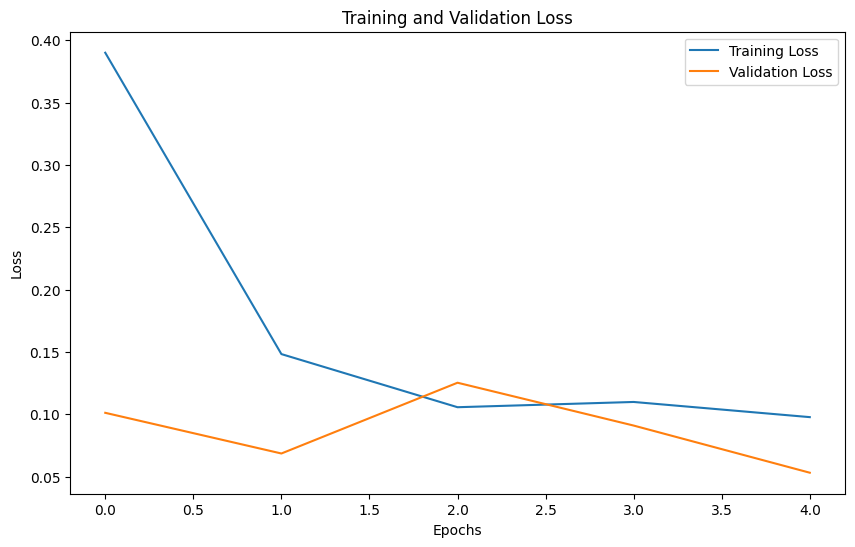

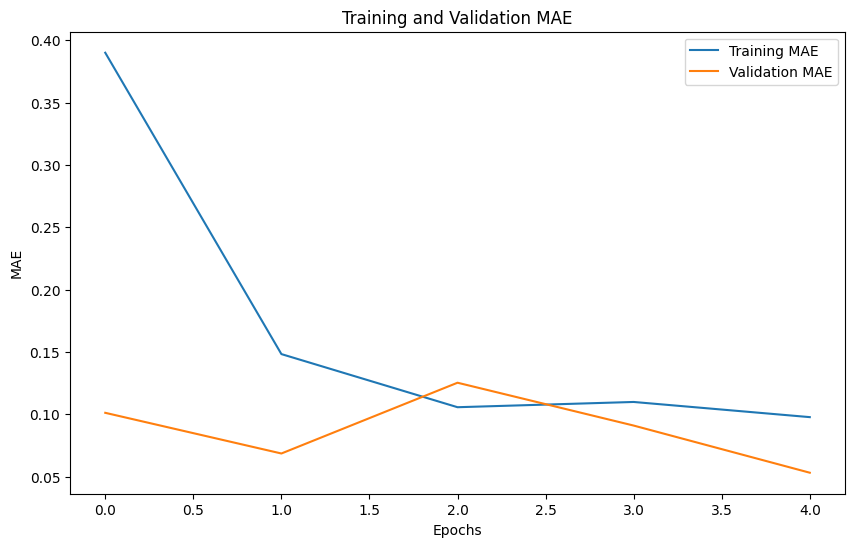

MSE metric not found in history.
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Reloading Tuner from ./keras_tuner_random_dir_fold_tf_2_0/hyperparameter_random_tuning_fold_tf_2_0/tuner0.json
Best hyperparameters for fold 0: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x140965130>
Epoch 1/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/step - loss: 0.7717 - mean_absolute_error: 0.7717 - val_loss: 0.1346 - val_mean_absolute_error: 0.1346
Epoch 2/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.2682 - mean_absolute_error: 0.2682 - val_loss: 0.0780 - val_mean_absolute_error: 0.0780
Epoch 3/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.2338 - mean_absolute_error: 0.2338 - val_loss: 0.0722 - val_mean_absolute_error: 0.0722
Epoch 4/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.2218 - mean_absolute_error: 0.2218 - val_loss: 0.0851 - val_mean_absolute_error: 0.0851
Epoch 5/5
31/31 

<Figure size 1000x600 with 0 Axes>

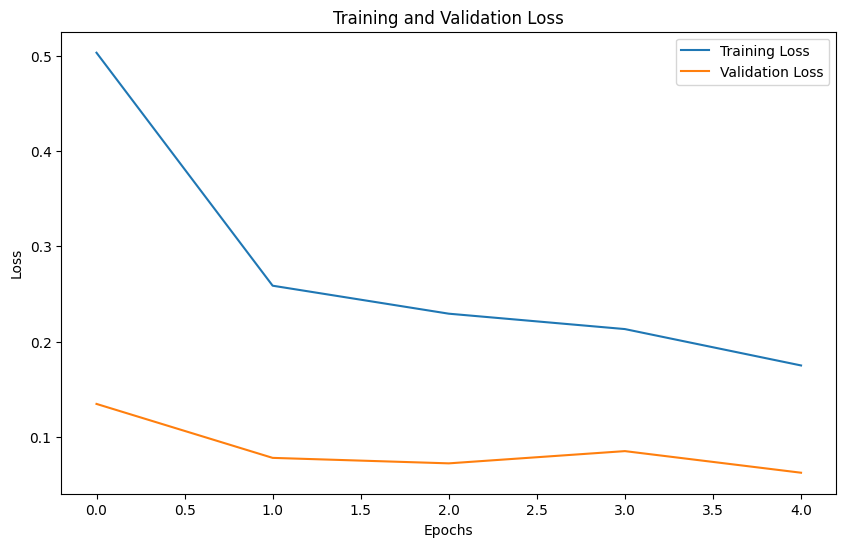

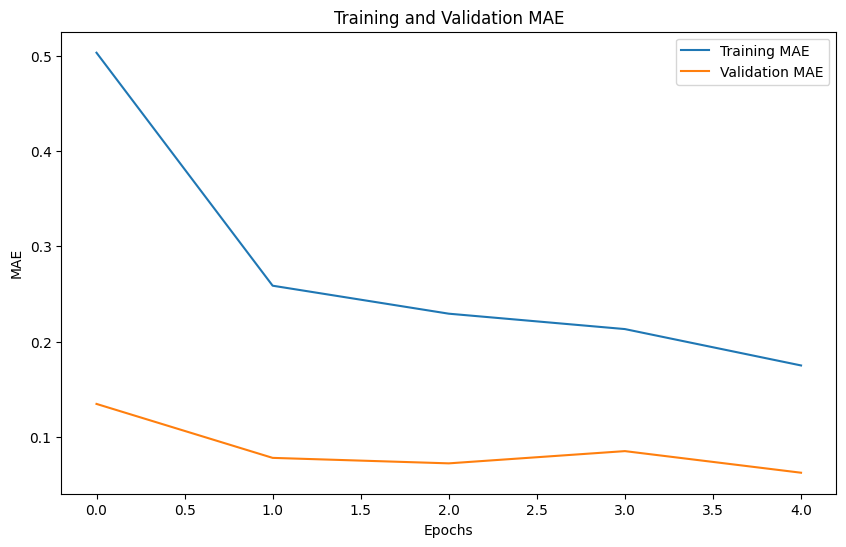

MSE metric not found in history.
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
Reloading Tuner from ./keras_tuner_random_dir_fold_tf_2_1/hyperparameter_random_tuning_fold_tf_2_1/tuner0.json
Best hyperparameters for fold 1: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x320acd520>
Epoch 1/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 0.9901 - mean_absolute_error: 0.9901 - val_loss: 0.1541 - val_mean_absolute_error: 0.1541
Epoch 2/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.1968 - mean_absolute_error: 0.1968 - val_loss: 0.0513 - val_mean_absolute_error: 0.0513
Epoch 3/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.1178 - mean_absolute_error: 0.1178 - val_loss: 0.0359 - val_mean_absolute_error: 0.0359
Epoch 4/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0900 - mean_absolute_error: 0.0900 - val_loss: 0.0468 - val_mean_absolute_error: 0.0468
Epoch 5/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0890 - mean_absolute_error: 0.0890 -

<Figure size 1000x600 with 0 Axes>

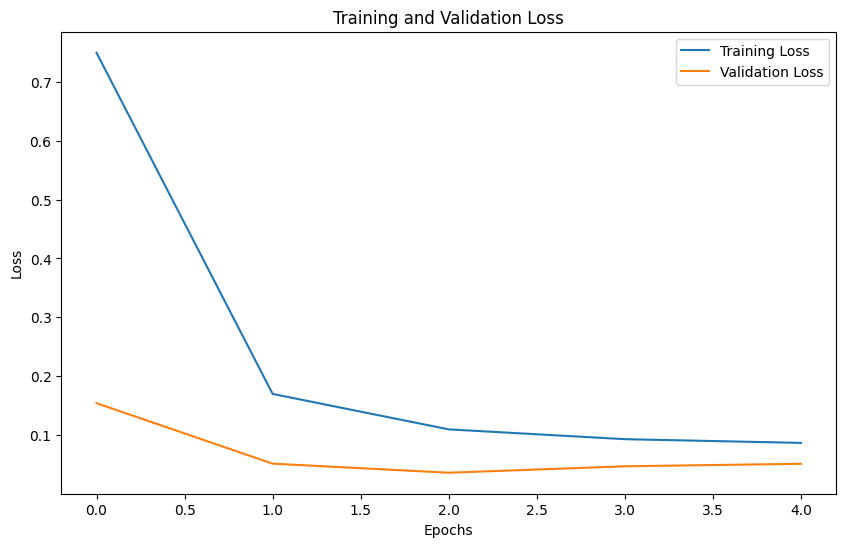

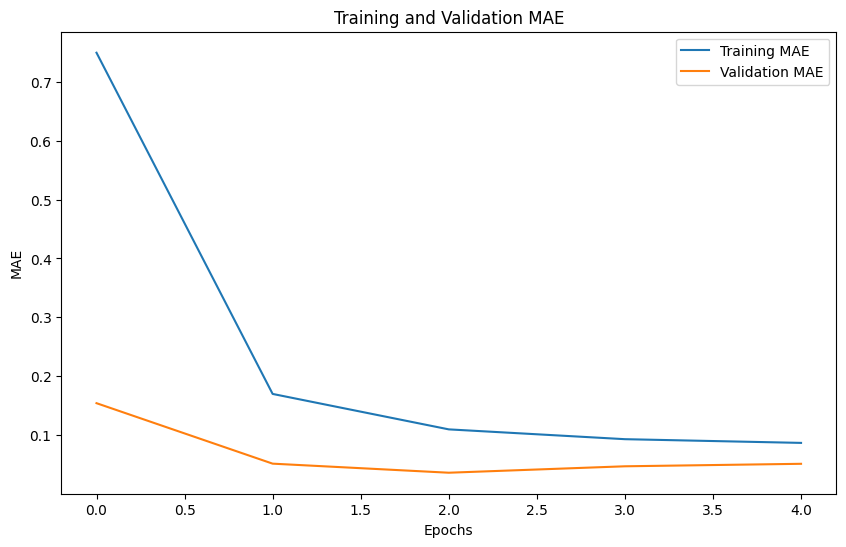

MSE metric not found in history.
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Reloading Tuner from ./keras_tuner_random_dir_fold_tf_3_0/hyperparameter_random_tuning_fold_tf_3_0/tuner0.json
Best hyperparameters for fold 0: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x36153fec0>
Epoch 1/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - loss: 0.4380 - mean_absolute_error: 0.4380 - val_loss: 0.1096 - val_mean_absolute_error: 0.1096
Epoch 2/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.2285 - mean_absolute_error: 0.2285 - val_loss: 0.1488 - val_mean_absolute_error: 0.1488
Epoch 3/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.2123 - mean_absolute_error: 0.2123 - val_loss: 0.1046 - val_mean_absolute_error: 0.1046
Epoch 4/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.1491 - mean_absolute_error: 0.1491 - val_loss: 0.1317 - val_mean_absolute_error: 0.1317
Epoch 5/5
31/31 ━

<Figure size 1000x600 with 0 Axes>

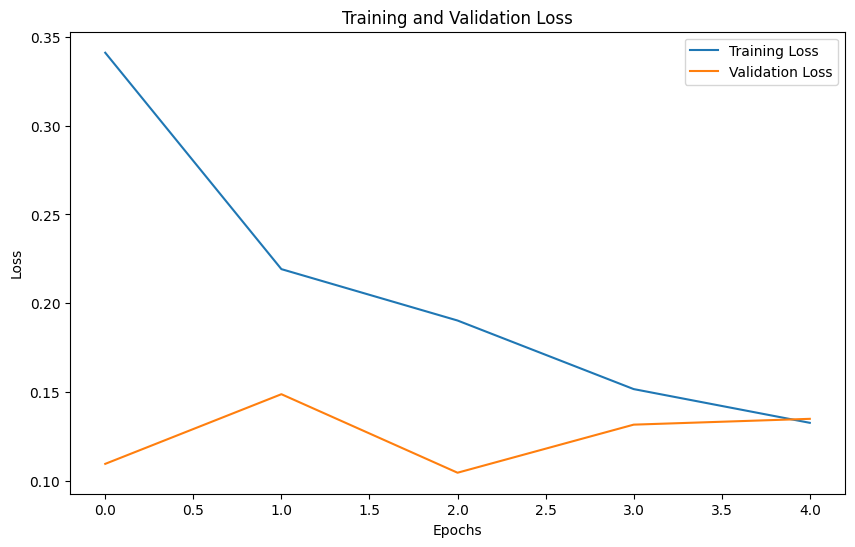

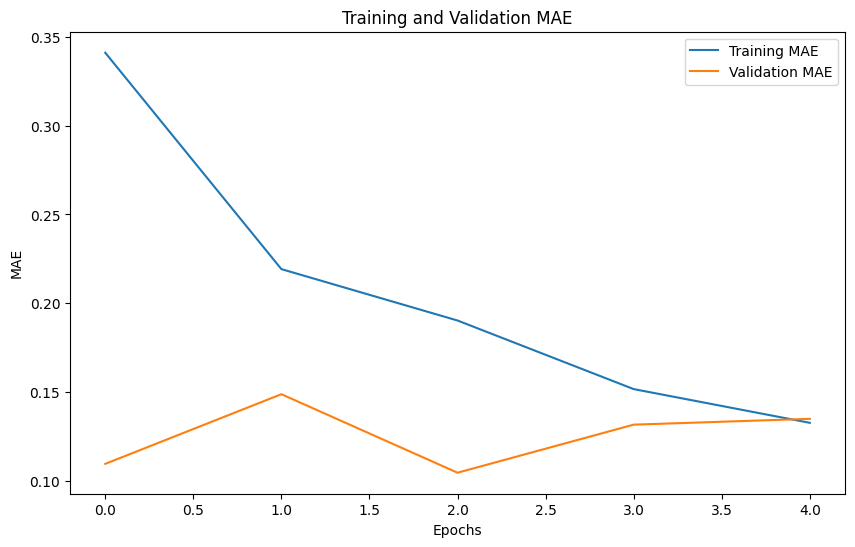

MSE metric not found in history.
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
Reloading Tuner from ./keras_tuner_random_dir_fold_tf_3_1/hyperparameter_random_tuning_fold_tf_3_1/tuner0.json
Best hyperparameters for fold 1: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x36695a540>
Epoch 1/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 1.0194 - mean_absolute_error: 1.0194 - val_loss: 0.1489 - val_mean_absolute_error: 0.1489
Epoch 2/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.2742 - mean_absolute_error: 0.2742 - val_loss: 0.1230 - val_mean_absolute_error: 0.1230
Epoch 3/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.2164 - mean_absolute_error: 0.2164 - val_loss: 0.1339 - val_mean_absolute_error: 0.1339
Epoch 4/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.1776 - mean_absolute_error: 0.1776 - val_loss: 0.0679 - val_mean_absolute_error: 0.0679
Epoch 5/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.1361 - mean_absolute_error: 0.1361 

<Figure size 1000x600 with 0 Axes>

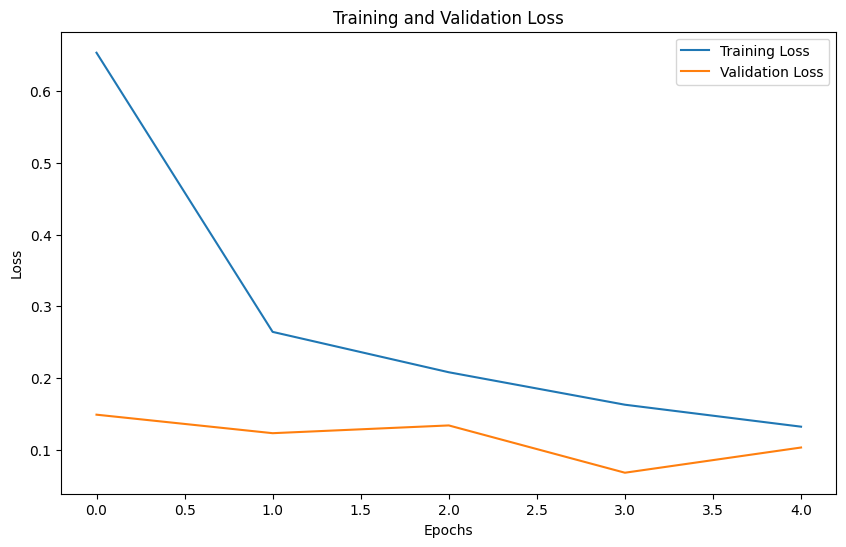

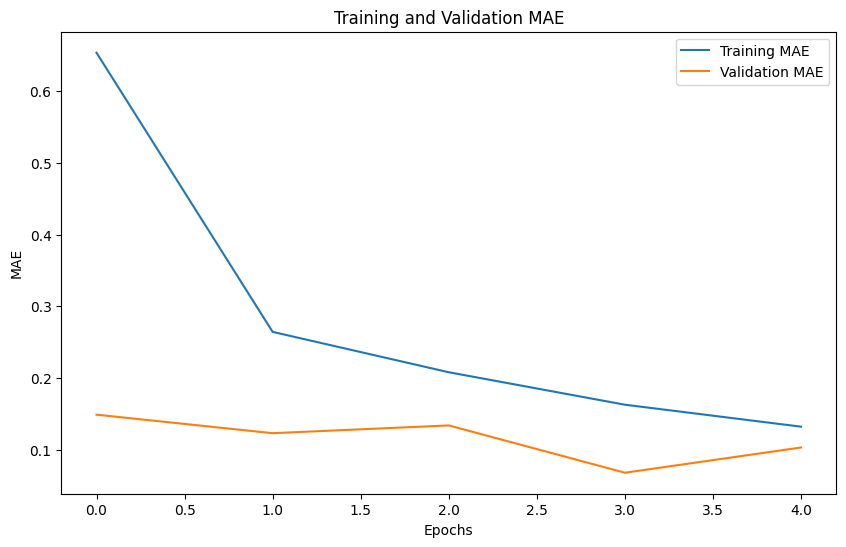

MSE metric not found in history.
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Reloading Tuner from ./keras_tuner_random_dir_fold_tf_4_0/hyperparameter_random_tuning_fold_tf_4_0/tuner0.json
Best hyperparameters for fold 0: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x3687d5190>
Epoch 1/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - loss: 0.3824 - mean_absolute_error: 0.3824 - val_loss: 0.1347 - val_mean_absolute_error: 0.1347
Epoch 2/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.2281 - mean_absolute_error: 0.2281 - val_loss: 0.2337 - val_mean_absolute_error: 0.2337
Epoch 3/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.1807 - mean_absolute_error: 0.1807 - val_loss: 0.1908 - val_mean_absolute_error: 0.1908
Epoch 4/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.1684 - mean_absolute_error: 0.1684 - val_loss: 0.2065 - val_mean_absolute_error: 0.2065
Epoch 5/5
31/31 ━

<Figure size 1000x600 with 0 Axes>

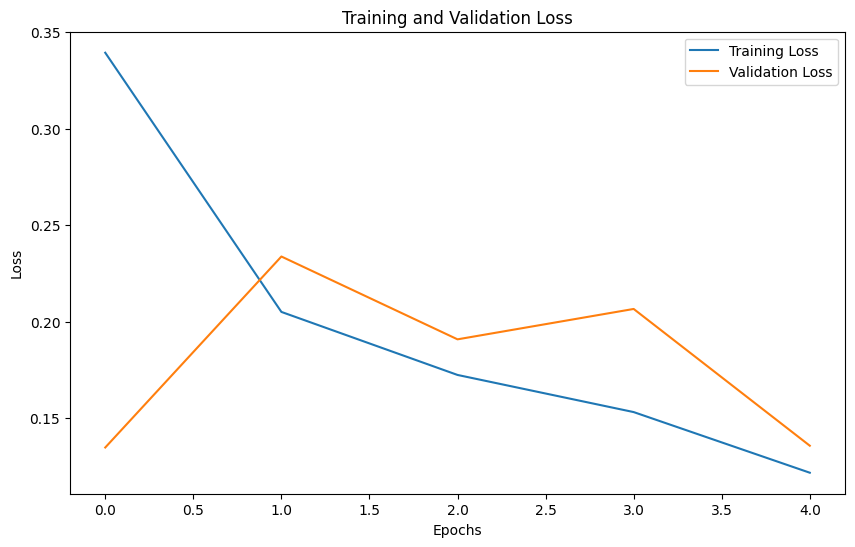

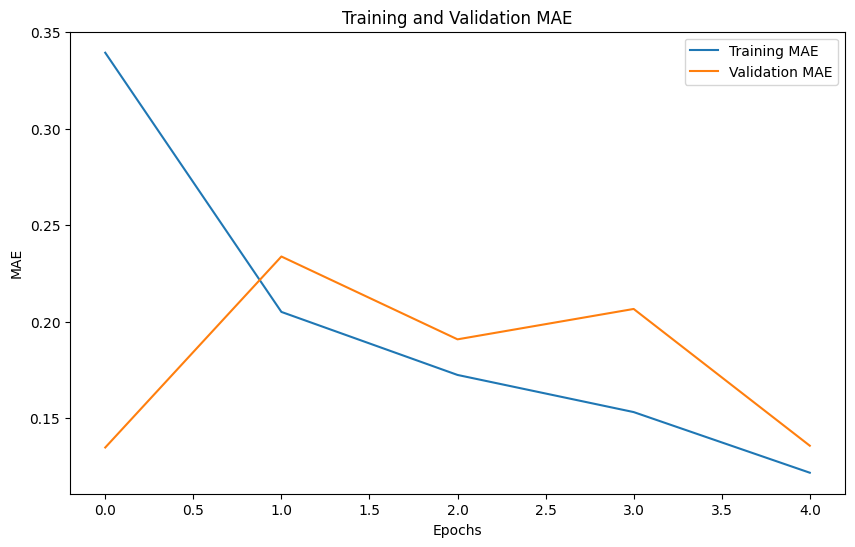

MSE metric not found in history.
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
Reloading Tuner from ./keras_tuner_random_dir_fold_tf_4_1/hyperparameter_random_tuning_fold_tf_4_1/tuner0.json
Best hyperparameters for fold 1: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x36d35ff80>
Epoch 1/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.2736 - mean_absolute_error: 0.2736 - val_loss: 0.0666 - val_mean_absolute_error: 0.0666
Epoch 2/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1642 - mean_absolute_error: 0.1642 - val_loss: 0.0648 - val_mean_absolute_error: 0.0648
Epoch 3/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1355 - mean_absolute_error: 0.1355 - val_loss: 0.0580 - val_mean_absolute_error: 0.0580
Epoch 4/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1309 - mean_absolute_error: 0.1309 - val_loss: 0.0583 - val_mean_absolute_error: 0.0583
Epoch 5/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1131 - mean_absolute_error: 0.1131 - v

<Figure size 1000x600 with 0 Axes>

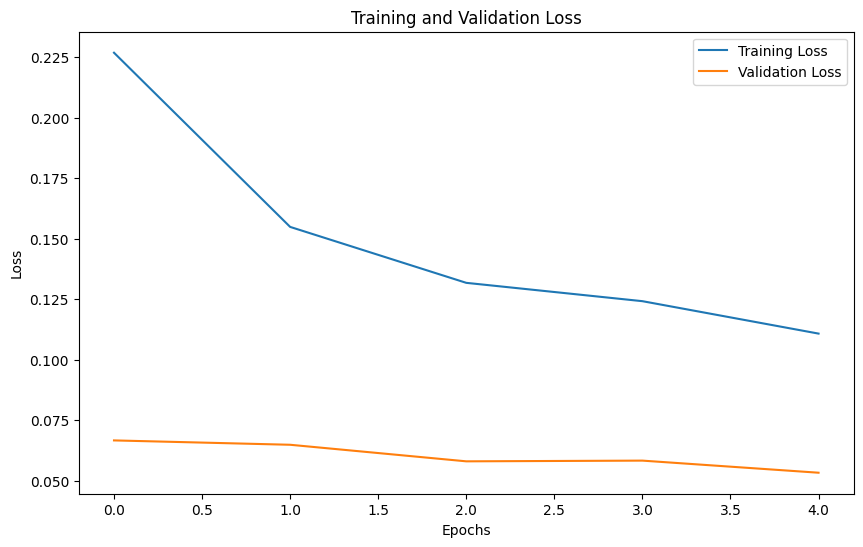

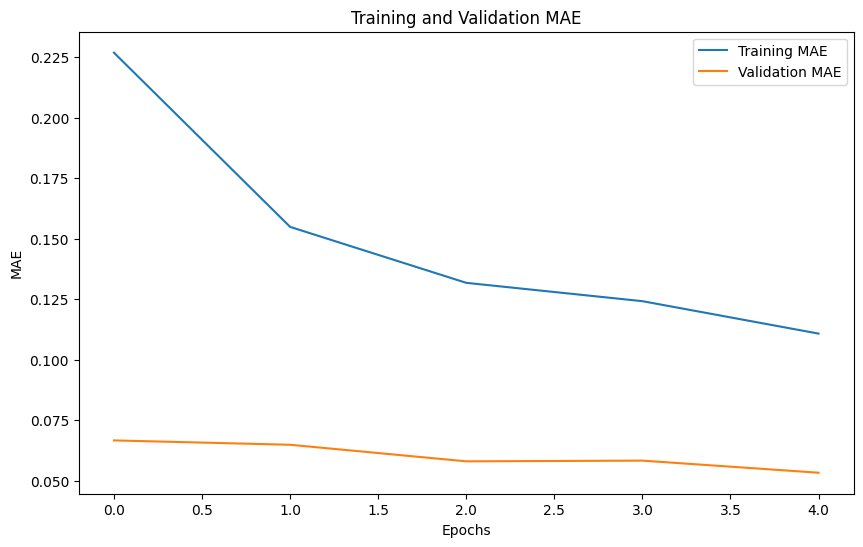

MSE metric not found in history.
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


<Figure size 1000x600 with 0 Axes>

In [43]:

for fold_outer_idx, (train_ix, test_ix) in enumerate(outer_cv.split(X)):
    X_train_outer, X_test_outer = X[train_ix], X[test_ix]
    y_train_outer, y_test_outer = y[train_ix], y[test_ix]
    inner_cv = KFold(n_splits=2, shuffle=True, random_state=42)
    for fold_idx, (train_ix_inner, val_ix) in enumerate(inner_cv.split(X_train_outer)):
        X_train_inner, X_val = X_train_outer[train_ix_inner], X_train_outer[val_ix]
        y_train_inner, y_val = y_train_outer[train_ix_inner], y_train_outer[val_ix]
        tuner = kt.RandomSearch(
            build_tft_model,
            objective='val_loss',
            max_trials=5,
            directory=f'./keras_tuner_random_dir_fold_tf_{fold_outer_idx}_{fold_idx}',
            project_name=f'hyperparameter_random_tuning_fold_tf_{fold_outer_idx}_{fold_idx}'
        )
        tuner.search(X_train_inner, y_train_inner, validation_data=(X_val, y_val), epochs=5)
        best_hps = tuner.oracle.get_best_trials(1)[0].hyperparameters
        print(f"Best hyperparameters for fold {fold_idx}: {best_hps}")
        model = build_tft_model(best_hps)
        es = [keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
        history=model.fit(X_train_inner, y_train_inner, validation_data=(X_val, y_val), epochs=5, batch_size=32, callbacks=es)
        plot_loss(history)
        plot_mae(history)
        plot_mse(history)
        y_pred = model.predict(X_val)
        mae = mean_absolute_error(y_val, y_pred)
        if mae < best_model_mae:
            best_model_mae = mae
            best_model_hyperparameters = best_hps
            best_model = model
        if mae > worst_model_mae:
            worst_model_mae = mae
            worst_model_hyperparameters = best_hps
            worst_model = model
    start_time = time.time()
    y_pred_best = best_model.predict(X_test_outer)
    y_pred_worst = worst_model.predict(X_test_outer)
    end_time = time.time()
    mse_best = mean_squared_error(y_test_outer, y_pred_best)
    mae_best = mean_absolute_error(y_test_outer, y_pred_best)
    rmse_best = np.sqrt(mse_best)
    r2_best = r2_score(y_test_outer, y_pred_best)
    time_duration = end_time - start_time
    mse_worst = mean_squared_error(y_test_outer, y_pred_worst)
    mae_worst = mean_absolute_error(y_test_outer, y_pred_worst)
    rmse_worst = np.sqrt(mse_worst)
    r2_worst = r2_score(y_test_outer, y_pred_worst)
    nested_scores.append({
        "Best Model": {
            "MSE": mse_best,
            "R^2": r2_best,
            "RMSE": rmse_best,
            "MAE": mae_best,
            "testing time": time_duration
        },
        "Worst Model": {
            "MSE": mse_worst,
            "R^2": r2_worst,
            "RMSE": rmse_worst,
            "MAE": mae_worst
        }
    })


In [44]:
print("Nested CV scores:", nested_scores)

Nested CV scores: [{'Best Model': {'MSE': np.float64(0.0099572333159431), 'R^2': 0.7814873551635675, 'RMSE': np.float64(0.09978593746587291), 'MAE': np.float64(0.06387782926746126), 'testing time': 0.9185962677001953}, 'Worst Model': {'MSE': np.float64(0.0067350300158441736), 'R^2': 0.8521989818739645, 'RMSE': np.float64(0.08206722863509022), 'MAE': np.float64(0.06494501975851077)}}, {'Best Model': {'MSE': np.float64(0.005260274983946392), 'R^2': 0.8812717048670456, 'RMSE': np.float64(0.07252775319797514), 'MAE': np.float64(0.05450645633150203), 'testing time': 0.2896919250488281}, 'Worst Model': {'MSE': np.float64(0.0065418127886569056), 'R^2': 0.8523464492167112, 'RMSE': np.float64(0.0808814737047793), 'MAE': np.float64(0.06714752248190449)}}, {'Best Model': {'MSE': np.float64(0.0020686359787086646), 'R^2': 0.9529723374516387, 'RMSE': np.float64(0.04548226004398489), 'MAE': np.float64(0.03503766521247673), 'testing time': 0.2869260311126709}, 'Worst Model': {'MSE': np.float64(0.00570

In [45]:
# Print Nested Cross-Validation Scores
print("Nested Cross-Validation Scores:")
for idx, score in enumerate(nested_scores):
    print(f"Fold {idx+1}:")
    print(f"  Best Model - MSE: {score['Best Model']['MSE']}, R^2: {score['Best Model']['R^2']}, RMSE: {score['Best Model']['RMSE']}, MAE: {score['Best Model']['MAE']}, Testing Time: {score['Best Model']['testing time']}")
    print(f"  Worst Model - MSE: {score['Worst Model']['MSE']}, R^2: {score['Worst Model']['R^2']}, RMSE: {score['Worst Model']['RMSE']}, MAE: {score['Worst Model']['MAE']}")

# Calculate averages for the best models across all folds
avg_best_mse = np.mean([score['Best Model']['MSE'] for score in nested_scores])
avg_best_mae = np.mean([score['Best Model']['MAE'] for score in nested_scores])
avg_best_r2 = np.mean([score['Best Model']['R^2'] for score in nested_scores])
avg_best_rmse = np.mean([score['Best Model']['RMSE'] for score in nested_scores])

# Print average metrics
print("\nAverage Best Model Metrics across all folds:")
print(f"Average MSE: {avg_best_mse}")
print(f"Average MAE: {avg_best_mae}")
print(f"Average R^2: {avg_best_r2}")
print(f"Average RMSE: {avg_best_rmse}")


Nested Cross-Validation Scores:
Fold 1:
  Best Model - MSE: 0.0099572333159431, R^2: 0.7814873551635675, RMSE: 0.09978593746587291, MAE: 0.06387782926746126, Testing Time: 0.9185962677001953
  Worst Model - MSE: 0.0067350300158441736, R^2: 0.8521989818739645, RMSE: 0.08206722863509022, MAE: 0.06494501975851077
Fold 2:
  Best Model - MSE: 0.005260274983946392, R^2: 0.8812717048670456, RMSE: 0.07252775319797514, MAE: 0.05450645633150203, Testing Time: 0.2896919250488281
  Worst Model - MSE: 0.0065418127886569056, R^2: 0.8523464492167112, RMSE: 0.0808814737047793, MAE: 0.06714752248190449
Fold 3:
  Best Model - MSE: 0.0020686359787086646, R^2: 0.9529723374516387, RMSE: 0.04548226004398489, MAE: 0.03503766521247673, Testing Time: 0.2869260311126709
  Worst Model - MSE: 0.0057059267689890955, R^2: 0.8702834131381645, RMSE: 0.07553758514136585, MAE: 0.06211018828299896
Fold 4:
  Best Model - MSE: 0.002322534956058694, R^2: 0.9445281198433357, RMSE: 0.048192685711202006, MAE: 0.03617177141277

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


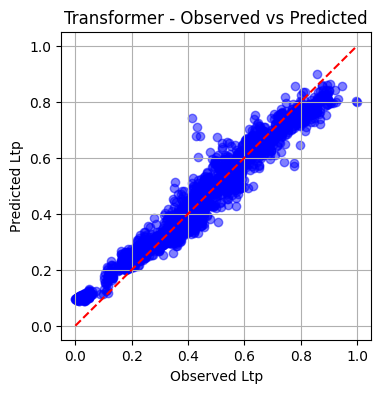

In [46]:

import matplotlib.pyplot as plt

# Predict using the best model
y_pred = best_model.predict(X).flatten()
y_observed = y.flatten()

# Plotting
plt.figure(figsize=(4,4))
plt.scatter(y_observed, y_pred, color='blue', alpha=0.5)
plt.plot([min(y_observed), max(y_observed)], [min(y_observed), max(y_observed)], color='red', linestyle='--')
plt.title('Transformer - Observed vs Predicted')
plt.xlabel('Observed Ltp')
plt.ylabel('Predicted Ltp')
plt.grid(True)
plt.show()

In [47]:
# Assuming best_model is your trained model
optimizer = best_model.optimizer
learning_rate = float(optimizer.learning_rate.numpy())

# Print the optimizer and learning rate
print("Optimizer:", type(optimizer).__name__)
print("Learning Rate:", learning_rate)

Optimizer: Adamax
Learning Rate: 0.004518796689808369


In [48]:
# Function to extract dropout rate from a layer
def get_dropout_rate(layer):
    if hasattr(layer, 'rate'):
        return layer.rate
    elif hasattr(layer, 'dropout'):
        return layer.dropout
    else:
        return None

# Iterate through layers of the model and find the dropout rates
dropout_rates = []

for layer in best_model.layers:
    rate = get_dropout_rate(layer)
    if rate is not None:
        dropout_rates.append((layer.name, rate))

# Print the dropout rates
print("Dropout Rates:")
for layer_name, rate in dropout_rates:
    print(f"{layer_name}: {rate}")


Dropout Rates:
lstm_12: 0.0
lstm_13: 0.0
multi_head_attention_32: 0.22416132576350759
dropout_107: 0.22416132576350759
dropout_108: 0.22416132576350759
multi_head_attention_33: 0.16152401332194163
dropout_110: 0.16152401332194163
dropout_111: 0.16152401332194163
multi_head_attention_34: 0.1
dropout_113: 0.1
dropout_114: 0.1
multi_head_attention_35: 0.1
dropout_116: 0.1
dropout_117: 0.1
dropout_118: 0.21304533422492086


In [49]:
best_hyperparameters_dict = best_model_hyperparameters.values
worst_hyperparameters_dict = worst_model_hyperparameters.values

print("Best Hyperparameters:", best_hyperparameters_dict)
print("Worst Hyperparameters:", worst_hyperparameters_dict)

Best Hyperparameters: {'num_transformer_blocks': 4, 'head_size': 168, 'num_heads': 2, 'ff_dim': 23, 'dropout_0': 0.22416132576350759, 'dropout_1': 0.16152401332194163, 'num_mlp_layers': 1, 'mlp_units_0': 64, 'mlp_dropout_0': 0.21304533422492086, 'optimizer': 'adamax', 'learning_rate': 0.004518796713876706, 'dropout_2': 0.1, 'dropout_3': 0.1, 'grn_units': 32}
Worst Hyperparameters: {'num_transformer_blocks': 2, 'head_size': 168, 'num_heads': 15, 'ff_dim': 15, 'dropout_0': 0.23346010246012824, 'dropout_1': 0.3112736201614076, 'num_mlp_layers': 3, 'mlp_units_0': 128, 'mlp_dropout_0': 0.44337451292222374, 'optimizer': 'adam', 'learning_rate': 0.001081503733245982, 'dropout_2': 0.5299040899555423, 'dropout_3': 0.12203084382057619, 'dropout_4': 0.5947422987142685, 'dropout_5': 0.17279591554642446, 'mlp_units_1': 32, 'mlp_dropout_1': 0.1, 'mlp_units_2': 32, 'mlp_dropout_2': 0.1, 'grn_units': 32}


In [50]:
# Assuming best_model is your final trained model
best_model.save('./STOCKtft.h5')

In [59]:
from keras.models import load_model
from keras.utils import plot_model

# Load the saved model
best_model = load_model('./STOCKtft.h5')

# Print model summary
print(best_model.summary())

# Visualize the model architecture and save the diagram to a file
plot_model(best_model, to_file='stocktft.png', show_shapes=True, show_layer_names=True, rankdir='TB')



TypeError: too many positional arguments

In [52]:
from tensorflow.keras.models import load_model

best_model='./STOCKtft.h5'
best_model = load_model('./STOCKtft.h5')


df_stock_scaled = df_stock.copy()
df_stock_scaled[features] = scaler.transform(df_stock[features])

# Make predictions
X_new, _ = df_to_X_y(df_stock_scaled, WINDOW_SIZE)
y_pred_new = best_model.predict(X_new)

TypeError: too many positional arguments

In [ ]:
y_pred_new

In [ ]:
print(y_pred_new.shape)



In [ ]:
y_pred_flat = y_pred_new.flatten() 

In [ ]:
print(X_new.shape)


In [ ]:

X_new_aggregated = X_new.mean(axis=(1, 2))  
X_new_slice = X_new[:, 0, 0]  


In [ ]:


plt.plot(X_new_aggregated, label='True Value')
plt.plot(y_pred_new, label='Predicted Model Value')
plt.xlabel('Time Scale')
plt.ylabel('Scaled NPR')
plt.legend()
plt.show()